In [1]:
from scipy import *
from numpy import *
from matplotlib.pyplot import *
from numpy.linalg import *
from scipy.linalg import *
import networkx as nx
from skimage import data as testimages
from skimage.color import rgb2gray
from scipy.io import loadmat

import FNC

In [2]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# Example 7.1.4

Here is the adjacency matrix of a "small-world" network on 200 nodes. Each node is connected to 4 neighbors, and then some edges are randomly changed to distant connections. 

In [3]:
wsg = nx.watts_strogatz_graph(200,4,0.02);

The adjacency matrix for this graph reveals the connections as mostly local (i.e., the nonzeros are near the diagonal).

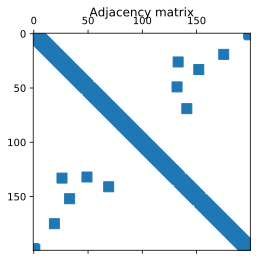

In [4]:
A = nx.adjacency_matrix(wsg);
spy(A);
title("Adjacency matrix");

# Example 7.1.5

We will use a test image from the well-known `skimage` module. 

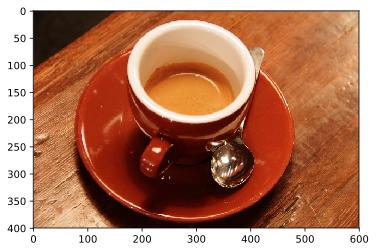

In [5]:
img = getattr(testimages,"coffee")()
imshow(img);

The details vary by image type, but for the most part an image is an array of color values.

In [6]:
print(img.shape)
img[0,0]

(400, 600, 3)


array([21, 13,  8], dtype=uint8)

The three values at each pixel are for intensities of red, green, and blue. We can convert each of those "planes" into an ordinary matrix.

In [7]:
R = img[:,:,0]
R[:5,:5]

array([[21, 21, 20, 21, 21],
       [21, 21, 20, 22, 20],
       [21, 23, 20, 21, 21],
       [21, 21, 21, 21, 20],
       [21, 21, 21, 21, 21]], dtype=uint8)

The values above go from zero (no red) to one (full red). It may also be convenient to convert the image to grayscale, which has just one "layer" from zero (black) to one (white). 

In [8]:
A = rgb2gray(img)
A[:5,:5]

array([[0.05623333, 0.05651608, 0.04978902, 0.05708157, 0.05903882],
       [0.05595059, 0.05651608, 0.05792275, 0.05987216, 0.05511725],
       [0.05875608, 0.05846549, 0.05848824, 0.05651608, 0.06212706],
       [0.05566784, 0.05651608, 0.05623333, 0.05679882, 0.05174627],
       [0.0553851 , 0.05595059, 0.05510235, 0.05595059, 0.05623333]])

# Example 7.2.1

The `eig` function from `scipy.linalg` will return the eigenvalues as a vector, and a matrix of associated eigenvectors.

In [9]:
A = pi*ones([2,2])
d,V = eig(A)
print("eigenvalues:",d);

eigenvalues: [ 6.28318531e+00+0.j -8.88178420e-16+0.j]


We can check the fact that this is an EVD.

In [10]:
D = diag(d)
norm( A - dot(V,dot(D,inv(V))), 2 )      

1.2560739669470201e-15

Even if the matrix is not diagonalizable, `eig` will run successfully, but the matrix ${V}$ will not be invertible.

In [11]:
d,V = eig([[1,1],[0,1]])
print("rank(V):",matrix_rank(V))

rank(V): 1


# Example 7.2.2

We will confirm the Bauer-Fike theorem on a triangular matrix. These tend to be far from normal. 

In [12]:
n = 15
lam = 1 + arange(n)
A = triu( outer(ones(n),lam) )
A[:5,:5]

array([[1., 2., 3., 4., 5.],
       [0., 2., 3., 4., 5.],
       [0., 0., 3., 4., 5.],
       [0., 0., 0., 4., 5.],
       [0., 0., 0., 0., 5.]])

The Bauer-Fike theorem provides an upper bound on the condition number of these eigenvalues.

In [13]:
d,V = eig(A)
print("condition number of V:",cond(V))

condition number of V: 71977672.64538044


The theorem suggests that eigenvalue changes may be up to 7 orders of magnitude larger than a perturbation to the matrix. A few random experiments show that effects of nearly that size are not hard to observe.

In [14]:
for k in range(3):
    E = randn(n,n);  E = 1e-7*E/norm(E,2);
    mu,V = eig(A+E)
    print("max change:",norm(sort(mu)-lam,Inf) )

max change: 0.5592750209777753
max change: 0.10715276620993386
max change: 0.023939464656541176


# Example 7.2.3

Let's start with a known set of eigenvalues and an orthogonal eigenvector basis.

In [15]:
D = diag([-6,-1,2,4,5])
V,R = qr(randn(5,5))
A = V@D@V.T      # note that V.T = inv(V)

Now we will take the QR factorization and just reverse the factors.

In [16]:
Q,R = qr(A)
A = R@Q

It turns out that this is a similarity transformation, so the eigenvalues are unchanged.

In [17]:
sort( eigvals(A) )

array([-6.+0.j, -1.+0.j,  2.+0.j,  4.+0.j,  5.+0.j])

What's remarkable is that if we repeat the transformation many times, the process converges to $D$. 

In [18]:
for k in range(40):
    Q,R = qr(A)
    A = R@Q

print(A)

[[-5.99999109e+00  9.89937003e-03 -4.86161388e-07  1.95575608e-16
  -2.94617683e-16]
 [ 9.89937003e-03  4.99999108e+00 -1.07183916e-04 -7.21032576e-17
  -6.08110833e-16]
 [-4.86161388e-07 -1.07183916e-04  4.00000001e+00 -6.89523008e-13
   1.06241143e-16]
 [ 4.50085804e-19  1.91212407e-16 -6.90755258e-13  2.00000000e+00
   1.18950967e-12]
 [-1.06320024e-31 -1.35814021e-28  4.59281468e-25  1.18974205e-12
  -1.00000000e+00]]


# Example 7.3.2

We verify some of the fundamental SVD properties using the function `svd` from `scipy.linalg`.

In [19]:
A = [[(i+1.0)**j for j in range(4)] for i in range(5) ]
A

[[1.0, 1.0, 1.0, 1.0],
 [1.0, 2.0, 4.0, 8.0],
 [1.0, 3.0, 9.0, 27.0],
 [1.0, 4.0, 16.0, 64.0],
 [1.0, 5.0, 25.0, 125.0]]

In [20]:
U,sigma,Vh = svd(A)

By default, the "full" type is returned. This can be a memory hog if one of the dimensions of $A$ is very large. 

In [21]:
print("size of U:",U.shape)
print("size of V:",Vh.shape)

size of U: (5, 5)
size of V: (4, 4)


Both $U$ and $V$ are orthogonal (in the complex case, unitary). Note that it's $V^*$ that is returned, not $V$.

In [22]:
print( norm(U.T@U - eye(5),2) )
print( norm(Vh@Vh.T - eye(4),2) )

1.371845172162743e-15
7.993056481202561e-16


Here are the singular values.

In [23]:
sigma

array([1.46697154e+02, 5.73856978e+00, 9.99848664e-01, 1.19280827e-01])

Next we test that we have the factorization promised by the SVD. The middle matrix is diagonal with the same size as $A$.

In [24]:
norm( A-U@diagsvd(sigma,5,4)@Vh, 2 )

7.935318460766495e-14

The 2-norm and condition number are typically computed from the singular values. 

In [25]:
print("2-norm:",sigma[0])
print("2-norm conditioning:",sigma[0]/sigma[-1])

2-norm: 146.69715365883005
2-norm conditioning: 1229.8468876337483


The "thin" SVD form is more memory efficient.

In [26]:
U,sigma,Vh = svd(A,full_matrices=False)
print("size of U:",U.shape)
print("size of V:",Vh.shape)

size of U: (5, 4)
size of V: (4, 4)


The thin form remains an exact factorization.

In [27]:
norm( A-U@diag(sigma)@Vh, 2 )

7.935318460766495e-14

# Example 7.4.1

The following matrix is not hermitian.

In [28]:
A = array([[0,2],[-2,0]])

It has an eigenvalue decomposition with a unitary matrix of eigenvectors, though, so it is normal. 

In [29]:
ev,V = eig(A)
norm( V.conj().T@V - eye(2), 2 )

2.220446049250313e-16

The eigenvalues are pure imaginary.

In [30]:
ev

array([0.+2.j, 0.-2.j])

The singular values are the complex magnitudes of the eigenvalues.

In [31]:
svdvals(A)

array([2., 2.])

# Example 7.4.2

We construct a real symmetric matrix with known eigenvalues by using the QR factorization to produce a random orthogonal set of eigenvectors. 

In [32]:
n = 30
ev = range(1,n+1) 

D = diag(ev)
V,R = qr(randn(n,n))   # get a random orthogonal V
A = V@D@V.T

The condition number of these eigenvalues is one. Thus the effect on them is bounded by the norm of the perturbation to $A$. 

In [33]:
for k in range(3):
    E = randn(n,n) 
    E = 1e-4*E/norm(E,2)
    mu = sort(eigvals(A+E))
    print("max change:",norm(mu-ev,Inf))

max change: 1.839195924802084e-05
max change: 2.016320960329665e-05
max change: 2.3568428321851798e-05


# Example 7.4.3

We construct a symmetric matrix with a known EVD.

In [34]:
n = 20
ev = range(1,n+1) 

D = diag(ev)
V,R = qr(randn(n,n))   # get a random orthogonal V
A = V@D@V.T

The Rayleigh quotient of an eigenvector is its eigenvalue.

In [35]:
R = lambda x: (x@A@x)/dot(x,x)
R(V[:,6])

7.000000000000003

The Rayleigh quotient's value is much closer to an eigenvalue than its input is to an eigenvector. In this experiment, each additional digit of accuracy in the eigenvector estimate gives two more digits to the eigenvalue estimate.

In [36]:
Delta = 1 / 10**arange(1,5)
print("perturbation size    R.Q. - λ")
for k,delta in enumerate(Delta):
    e = randn(n);  
    e = delta*e/norm(e)
    x = V[:,6] + e
    quotient = R(x)
    print(f"{delta:12.1e}        {quotient-8:.3e}")

perturbation size    R.Q. - λ
     1.0e-01        -9.593e-01
     1.0e-02        -9.998e-01
     1.0e-03        -1.000e+00
     1.0e-04        -1.000e+00


# Example 7.5.1

We make an image from some text, then reload it as a matrix.

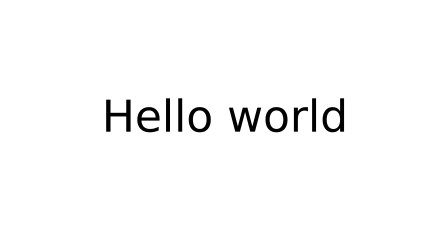

In [37]:
text(0.5,0.5,"Hello world",
     dict(fontsize=44),horizontalalignment="center",verticalalignment="center")
axis("off");
savefig("hello.png");

In [38]:
img = imread("hello.png");
A = rgb2gray(img)
print(A.shape)

(288, 504)


Next we show that the singular values decrease exponentially, until they reach zero (more precisely, are about $\sigma_1 \varepsilon_\text{mach}$). For all numerical purposes, this determines the rank of the matrix.

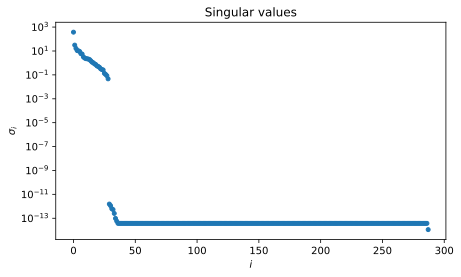

In [39]:
U,sigma,Vt = svd(A)
semilogy(sigma,"o")
title("Singular values"); 
xlabel("$i$"); ylabel("$\sigma_i$");

In [40]:
max(where(sigma/sigma[0] > 10*2**-52)[0])

30

The rapid decrease suggests that we can get fairly good low-rank approximations. 

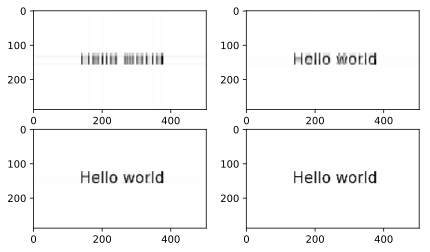

In [41]:
for k in range(4):
    r = 2+2*k
    Ak = U[:,:r]@diag(sigma[:r])@Vt[:r,:]
    subplot(2,2,k+1)
    imshow(Ak,cmap="gray",clim=(0.,1.))

Consider how little data is needed to reconstruct these images. For rank 8, for instance, we have 8 left and right singular vectors plus 8 singular values, for a compression ratio of better than 25:1.  

In [42]:
m,n = A.shape
print("compression:",8*(m+n+1) / (m*n))

compression: 0.043705908289241625


# Example 7.5.2

This matrix describes the votes on bills in the 111th session of the United States Senate. (The data set was obtained from voteview.com.) Each row is one senator and each column is a vote item.

In [43]:
vars = loadmat("voting.mat")
A = vars["A"]
m,n = A.shape
print("size:",(m,n))

size: (112, 696)


If we visualize the votes (white is "yea," black is "nay," and gray is anything else), we can see great similarity between many rows, reflecting party unity.

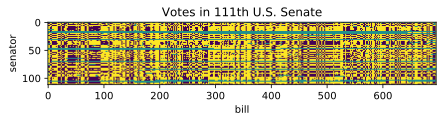

In [44]:
imshow(A,cmap="viridis")
xlabel("bill"); ylabel("senator");
title("Votes in 111th U.S. Senate");

We use singular value "energy" to quantify the decay rate of the values. 

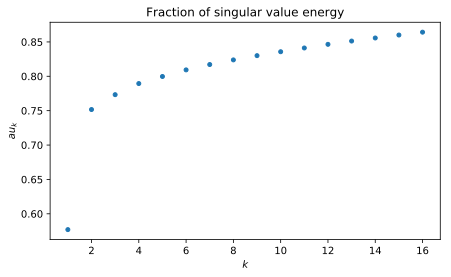

In [45]:
U,sigma,Vt = svd(A)
tau = cumsum(sigma**2) / sum(sigma**2)
plot(range(1,17),tau[:16],"o")
xlabel("$k$"); ylabel("$\tau_k$"); 
title("Fraction of singular value energy");

The first and second singular triples contain about 58% and 17% respectively of the energy of the matrix. All others have far less effect, suggesting that the information is primarily two-dimensional. The first left and right singular vectors also contain interesting structure.

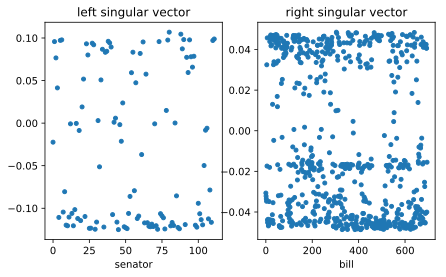

In [46]:
subplot(1,2,1)
plot(U[:,0],"o") 
xlabel("senator"); title("left singular vector");
subplot(1,2,2)
plot(Vt[0,:],"o") 
xlabel("bill"); title("right singular vector");

Both vectors have values greatly clustered near $\pm C$  for a constant $C$. These can be roughly interpreted as how partisan a particular senator or bill was, and for which political party.   Projecting the senators' vectors into the first two $V$-coordinates gives a particularly nice way to reduce them to two dimensions. Political scientists label these dimensions "partisanship" and "bipartisanship." Here we color them by actual party affiliation (also given in the data file): red for Republican, blue for Democrat, and yellow for independent. 

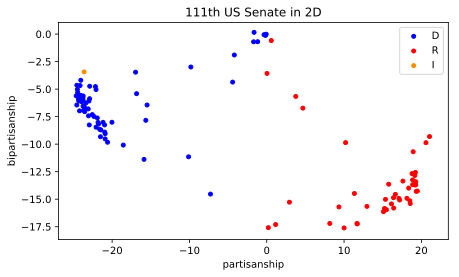

In [47]:
x1 = sigma[0]*U[:,0];   x2 = sigma[1]*U[:,1];

Rep = vars["Rep"]-1; Dem = vars["Dem"]-1;  Ind = vars["Ind"]-1;

scatter(x1[Dem],x2[Dem],color="blue",label="D")
scatter(x1[Rep],x2[Rep],color="red",label="R")
scatter(x1[Ind],x2[Ind],color="darkorange",label="I")

xlabel("partisanship"); ylabel("bipartisanship");
legend(); title("111th US Senate in 2D");